## **Question 1**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Part 1**

In [ ]:
import torch
import torchvision
from torchvision import transforms

# Define augmentations for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=5),
    transforms.RandomCrop(size=28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define transformations for the testing and validation datasets
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transforms, download=True)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=test_transforms, download=True)

# Split the train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# # Create data loaders for the datasets
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 120404259.60it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32935207.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41498751.28it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4838843.98it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### **Part 2**

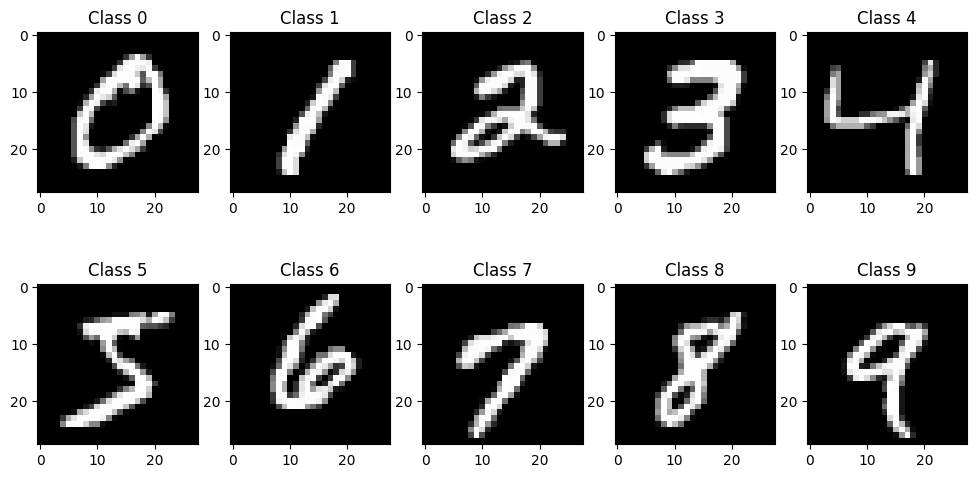

In [ ]:
# Plot a few images from each class
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    idx = train_dataset.dataset.targets == i
    axs[i//5][i%5].imshow(train_dataset.dataset.data[idx][0], cmap='gray')
    axs[i//5][i%5].set_title(f'Class {i}')
plt.show()


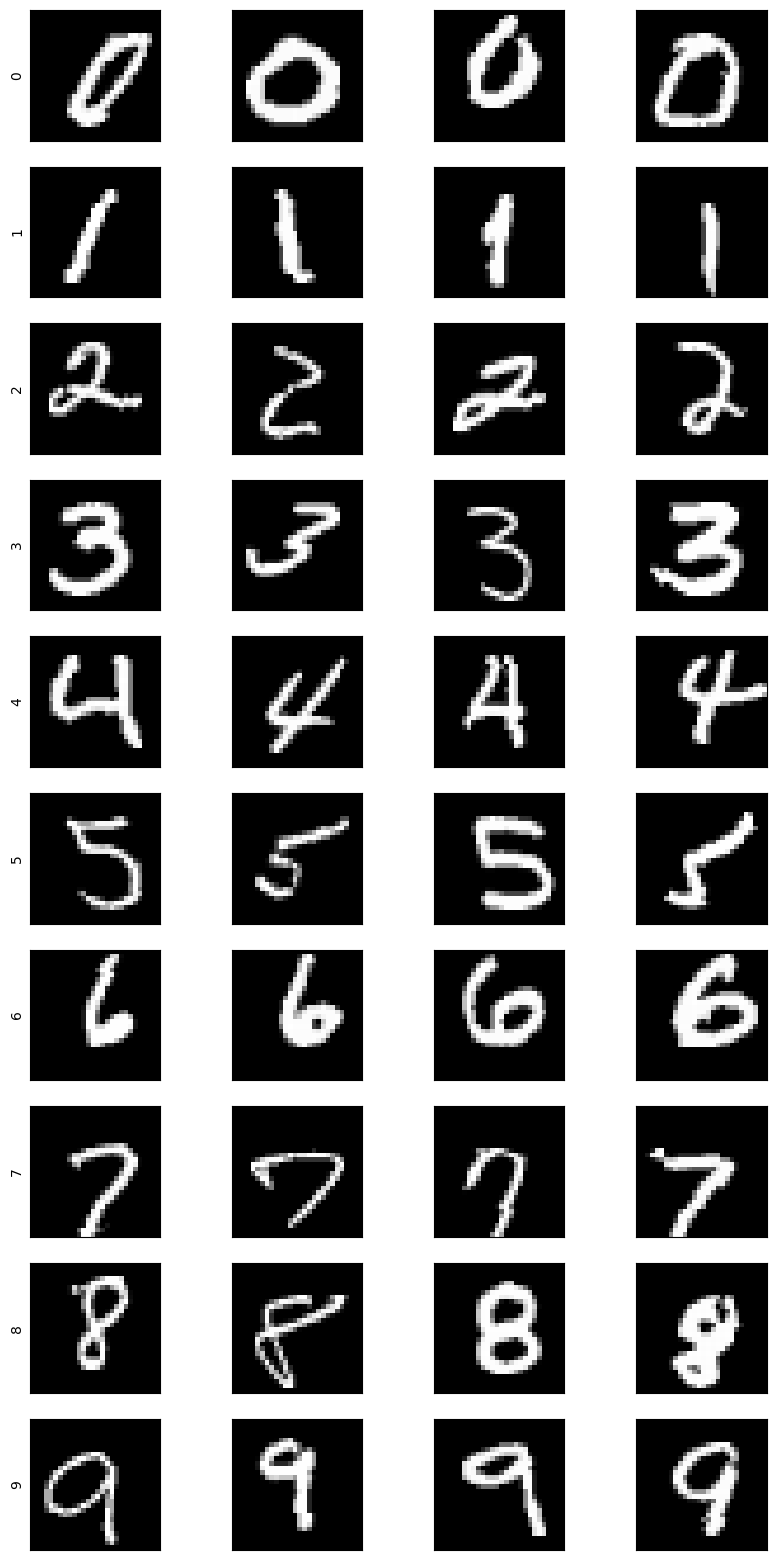

In [ ]:
#Defining the classes
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

#Get the indices of each class
class_idx = {}
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    class_idx.setdefault(label, []).append(i)

# Plot a few images from each class
fig, axs = plt.subplots(len(classes), 4, figsize=(10, 20))
samples_per_class = 4
for i, cls in enumerate(classes):
    class_samples = np.random.choice(class_idx[int(cls)], samples_per_class, replace=False)
    for j in range(samples_per_class):
        img, label = train_dataset[class_samples[j]]
        axs[i, j].imshow(img.squeeze(), cmap='gray')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        if j == 0:
            axs[i, j].set_ylabel(cls)

# Create data loaders for the training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

### **Part 3**

In [ ]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = MLP(input_dim=784, hidden_dim=256, output_dim=10)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)


Number of trainable parameters: 269322


### **Part 4**

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm

# Define the training parameters
learning_rate = 0.001
num_epochs = 5
input_size = 784 # 28x28 pixels
hidden_size = 128
output_size = 10

# Initialize the model and optimizer
model = MLP(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Define variables for logging
best_acc = 0.0
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0.0
    model.train() # Set the model to training mode

    for images, labels in tqdm(train_loader):
        # Flatten the images
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the accuracy and loss
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item() * images.size(0)

    train_acc = train_correct / len(train_dataset)
    train_loss /= len(train_dataset)

    # Evaluate the model on the validation set
    val_loss = 0.0
    val_correct = 0.0
    model.eval() # Set the model to evaluation mode

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            # Flatten the images
            images = images.view(images.size(0), -1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate the accuracy and loss
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_loss += loss.item() * images.size(0)

    val_acc = val_correct / len(val_dataset)
    val_loss /= len(val_dataset)

    # Save the best model based on validation accuracy
    if val_acc > best_acc:
        torch.save(model.state_dict(), 'best_model.pth')
        best_acc = val_acc

    # Log the training and validation accuracy and loss
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))
    print('\n')
# Print the final results
print('Best Validation Accuracy: {:.4f}'.format(best_acc))
print('Final Training Accuracy: {:.4f}'.format(train_acc_list[-1]))
print('Final Validation Accuracy: {:.4f}'.format(val_acc_list[-1]))


100%|██████████| 188/188 [00:05<00:00, 33.41it/s]


Epoch [1/5], Train Loss: 0.4769, Train Acc: 0.8506, Val Loss: 0.2454, Val Acc: 0.9267




100%|██████████| 188/188 [00:06<00:00, 29.49it/s]


Epoch [2/5], Train Loss: 0.2020, Train Acc: 0.9379, Val Loss: 0.1727, Val Acc: 0.9474




100%|██████████| 188/188 [00:05<00:00, 33.78it/s]


Epoch [3/5], Train Loss: 0.1594, Train Acc: 0.9510, Val Loss: 0.1728, Val Acc: 0.9467




100%|██████████| 188/188 [00:06<00:00, 30.30it/s]


Epoch [4/5], Train Loss: 0.1344, Train Acc: 0.9584, Val Loss: 0.1339, Val Acc: 0.9609




100%|██████████| 188/188 [00:05<00:00, 31.92it/s]

Epoch [5/5], Train Loss: 0.1259, Train Acc: 0.9611, Val Loss: 0.1366, Val Acc: 0.9605


Best Validation Accuracy: 0.9609
Final Training Accuracy: 0.9611
Final Validation Accuracy: 0.9605


### **Part 5**

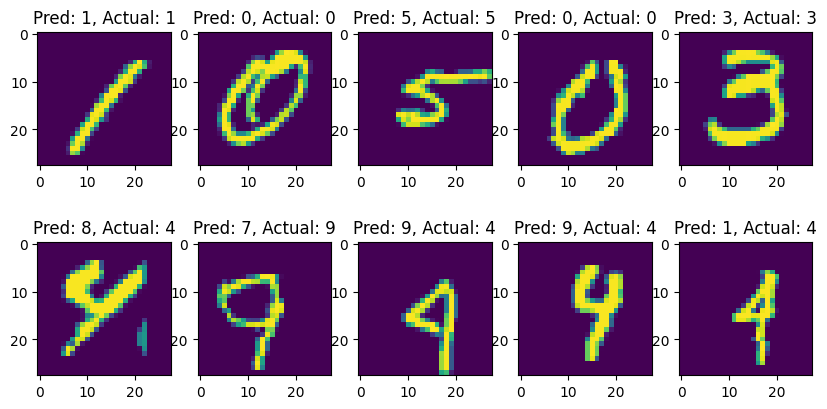

In [ ]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize variables to keep track of correct and incorrect predictions
correct_preds = []
incorrect_preds = []

# Loop over the validation dataset
for images, labels in val_loader:
    
    # Flatten the input images
    images = images.view(images.size(0), -1)
    
    # Forward pass
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    
    # Append the correct and incorrect predictions to the lists
    for i in range(len(preds)):
        if preds[i] == labels[i]:
            correct_preds.append((images[i], preds[i], labels[i]))
        else:
            incorrect_preds.append((images[i], preds[i], labels[i]))

# Visualize the correct and incorrect predictions
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axs[0][i].imshow(correct_preds[i][0].reshape(28, 28))
    axs[0][i].set_title("Pred: {}, Actual: {}".format(correct_preds[i][1], correct_preds[i][2]))
    axs[1][i].imshow(incorrect_preds[i][0].reshape(28, 28))
    axs[1][i].set_title("Pred: {}, Actual: {}".format(incorrect_preds[i][1], incorrect_preds[i][2]))
plt.show()


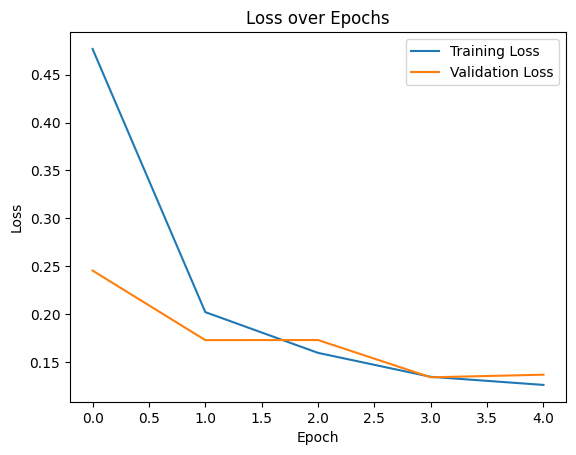

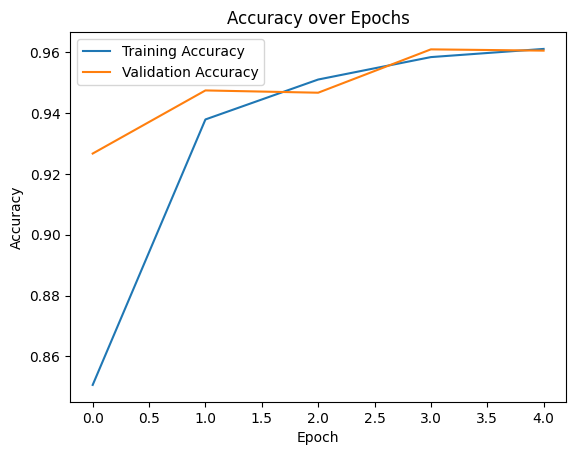

In [ ]:
# Plot the loss over the epochs
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plot the accuracy over the epochs
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


## **Question 2**

### **Part 1**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

dataset2 = pd.read_csv("/content/drive/MyDrive/prml/lab-9/abalone.data", header=None,names=['Sex','Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight','Rings'])
dataset2

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [2]:
#Converting the categorical variable 'Sex' to numerical using one-hot encoding
dataset2 = pd.concat([dataset2, pd.get_dummies(dataset2['Sex'], prefix='Sex')], axis=1)
dataset2.drop(['Sex'], axis=1, inplace=True)
dataset2

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11,1,0,0
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10,0,0,1
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9,0,0,1
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10,1,0,0


In [3]:
# Normalize the numerical variables using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_vars = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
dataset2[num_vars] = scaler.fit_transform(dataset2[num_vars])
dataset2

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex_F,Sex_I,Sex_M
0,-0.574558,-0.432149,-1.064424,-0.641898,-0.607685,-0.726212,-0.638217,15,0,0,1
1,-1.448986,-1.439929,-1.183978,-1.230277,-1.170910,-1.205221,-1.212987,7,0,0,1
2,0.050033,0.122130,-0.107991,-0.309469,-0.463500,-0.356690,-0.207139,9,1,0,0
3,-0.699476,-0.432149,-0.347099,-0.637819,-0.648238,-0.607600,-0.602294,10,0,0,1
4,-1.615544,-1.540707,-1.423087,-1.272086,-1.215968,-1.287337,-1.320757,7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4172,0.341509,0.424464,0.609334,0.118813,0.047908,0.532900,0.073062,11,1,0,0
4173,0.549706,0.323686,-0.107991,0.279929,0.358808,0.309362,0.155685,10,0,0,1
4174,0.632985,0.676409,1.565767,0.708212,0.748559,0.975413,0.496955,9,0,0,1
4175,0.841182,0.777187,0.250672,0.541998,0.773341,0.733627,0.410739,10,1,0,0


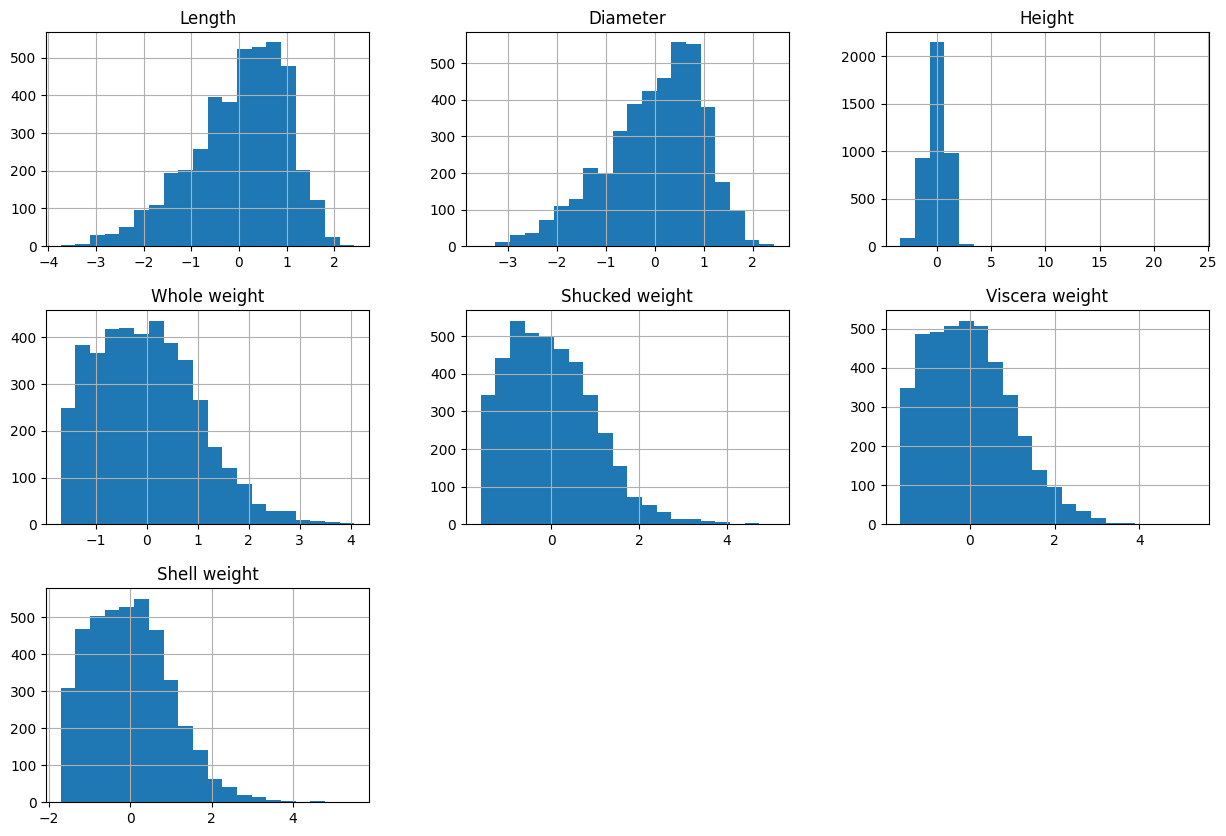

In [4]:
# Visualize the distribution of numerical variables using histograms
dataset2[num_vars].hist(bins=20, figsize=(15, 10))
plt.show()

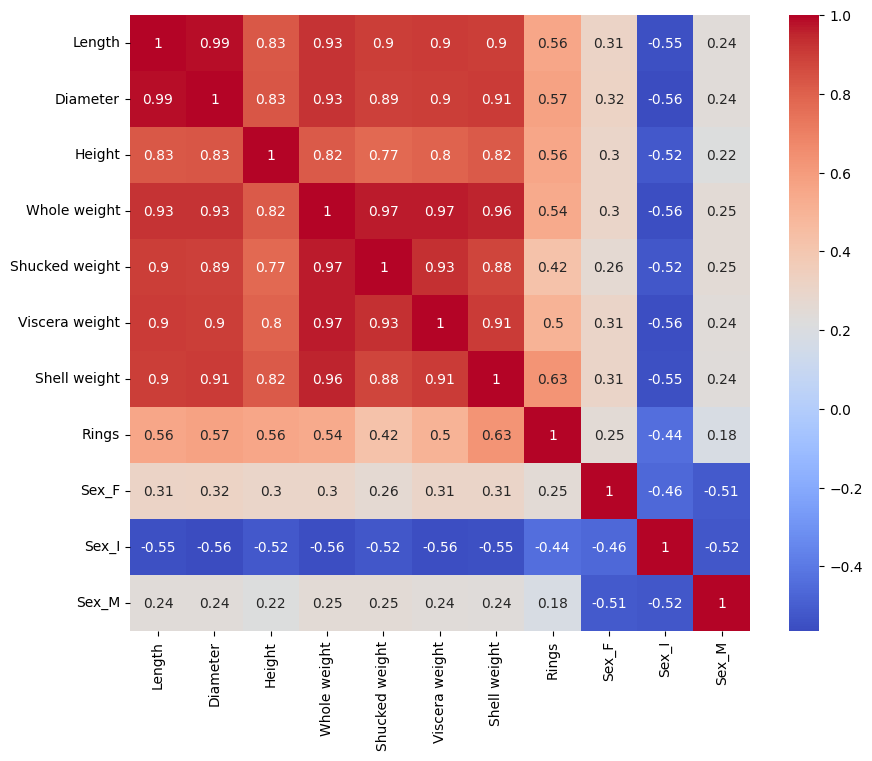

In [5]:
# Visualize the correlation between features using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(dataset2.corr(), cmap='coolwarm', annot=True)
plt.show()

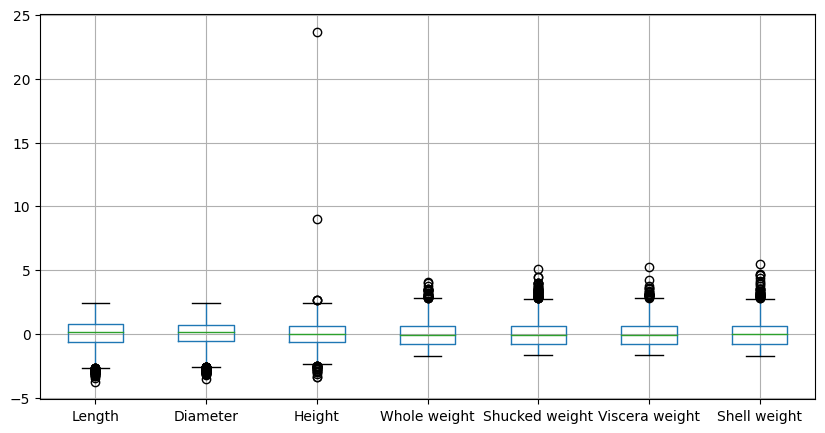

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
dataset2.boxplot(column=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight'], ax=ax)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

X_que2 = dataset2.drop('Rings', axis=1)
y_que2 = dataset2['Rings']


In [10]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_que2, y_que2)

X_trainval, X_test, y_trainval, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)


### **Part 2: MLP from Scratch**

### Activation functions

In [11]:
def relu(x):
  if x<=0:
    return 0
  else:
    return x

def sigm(x):
  y=  1/(1+ np.exp(-x))  
  return y

def tanh(x):
  y = (np.exp(x)- np.exp(-x))/( np.exp(x) + np.exp(-x))
  return y

def i(x):
  return x

### Forward Propagation

In [13]:
class MLP:
  def __init___(self):
    self.network=[]
    self.layer_count= len(self.network)
    self.neuron_count= []
    self.weights= []
    self.biases= []
    self.activations= []


  def dense( self, neuron_count, active='i'):
    self.neuron_count.append( neuron_count)
    layer= np.zeros( (neuron_count, 1), dtype= float)
    self.network.append(layer)
    self.activations.append(active )
    self.layer_count= len(self.network)

  def init(self):
    for i in range(self.layer_count-1):
      self.biases.append( np.random.rand())
    
    for i in range(1, self.layer_count):
      matrix= np.random.randn( neuron_count[i], neuron_count[i-1])
      self.weights.append( matrix)

  def forward(self, x):
    self.network[0]= np.array(x)
    for i in range(1, self.layer_count):
      bias= np.rand()
      self.biases.append(bias)
      wx_b= np.array(self.weights[i-1] @ self.network[i-1]) + bias

      if self.activations[i]=='relu':
        self.network[i]= relu(wx_b)
      elif self.activations[i]== 'tanh':
        self.network[i]= tanh(wx_b)
      elif self.activation[i]== 'sigm':
        self.network[i]= sigm(wx_b)
      else:
        self.network[i]= i(wx_b)

      return network[self.layer_count-1]


In [48]:
# Initialize a network
from random import seed
from random import random

def init(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  network = []
  hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(hiddens[0] )]
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ):
    n_count= hiddens[i] 
    w_count= hiddens[i-1]+1 
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( random())
      hidden_layer.append({'weights': weights})
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

  output_layer = [{'weights':[random() for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network

network = init(2, [1, 2], 2,['relu','relu','relu','relu'])
for layer in network:
  print(layer)


[{'weights': [0.9989000154992786, 0.6726347472246018, 0.14056088838086367]}, {'activation': 'relu'}]
[{'weights': [0.28249087013687946, 0.5149752904584157]}, {'weights': [0.18010363747197666, 0.5030694252163678]}, {'activation': 'relu'}]
[{'weights': [0.4946799130002577, 0.8533615132681343, 0.26998885895850366]}, {'weights': [0.022351889175037942, 0.18235304521965845, 0.5237968755356037]}, {'activation': 'relu'}]


In [49]:
## For constant initializations

def init_k(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  k= random()
  network = []
  hidden_layer = [{'weights':[k for i in range(n_inputs + 1)]} for i in range(hiddens[0] )] 
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ):
    n_count= hiddens[i] 
    w_count= hiddens[i-1]+1 
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( k)
      hidden_layer.append({'weights': weights})
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

  output_layer = [{'weights':[k for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network


In [50]:
## For 0 initialization

def init_zero(n_inputs, hiddens, n_outputs,activ): 
  '''hiddens is a list
      where length of list is the number of hidden layer we have
      and value at each index is the number of neurons in that list'''
  network = []
  hidden_layer = [{'weights':[0 for i in range(n_inputs + 1)]} for i in range(hiddens[0] )]
  hidden_layer.append({'activation': activ[0]})
  network.append(hidden_layer)
 
  for i in range(1, len(hiddens) ):
    n_count= hiddens[i] 
    w_count= hiddens[i-1]+1 
    hidden_layer=[] 
    for j in range( n_count): 
      weights=[]
      for k in range( w_count): 
        weights.append( 0)
      hidden_layer.append({'weights': weights}) 
    hidden_layer.append({'activation':activ[i]})
    network.append( hidden_layer)

  output_layer = [{'weights':[0 for k in range(hiddens[-1] + 1)]} for j in range(n_outputs)]
  output_layer.append({'activation':activ[-1]})
  network.append(output_layer)
  return network
     

In [51]:
# Firing of our neuron

def fire(weights, inputs):
  wx_b = weights[-1]
  for i in range(len(weights)-1):
    wx_b += weights[i] * inputs[i]

  return wx_b

In [52]:
def forward_propagate(network, data):
	input = data
	for layer in network:
		new_input = []
		for neuron in layer[:-1]:
			temp = fire( neuron['weights'], input)
			if layer[-1]['activation']=='relu':
				 neuron['output']= relu(temp)
			elif layer[-1]['activation']=='sigmoid':
				 neuron['output']= sigm(temp)
			elif layer[-1]['activation']=='tanh':
				 neuron['output']= tanh(temp)
			else:
				 neuron['output']= temp
			new_input.append(neuron['output'])
		input = new_input
	return input

network= init( 2, [1, 3, 2], 3,['relu','relu','relu','relu','relu'])
output= forward_propagate( network, [2, 4])
print(output)

[2.1435383220761244, 4.927438637994847, 1.7883117629245724]


### Backward Propagation

In [19]:
def anti_activation(x, activation= 'i'):
  if activation=='relu':
    if x>0:
      return 1
    else: return 0 
  if activation=='tanh':
    return 1-x**2
  if activation=='sigm':
    return x*(1-x)
  else:
    return 1

In [53]:
def back_propagate(network, expected):
  for i in range( len(network)- 1, -1, -1):
    layer, error_layer = network[i], []
		
    if i != len(network)-1: #if it isnt the last layer, calculation of error is not staright forward
      for j in range(len(layer)-1):
        error_neuron = 0.0
        for neuron in network[i + 1][:-1]:
          error_neuron += (neuron['weights'][j] * neuron['delta'])
        error_layer.append(error_neuron)
    else: #if it is the last layer, calculation is rather straihtforward
      for j in range(len(layer)-1):
        neuron = layer[j]
        error_layer.append(-neuron['output'] + expected[j])
    
    for j in range(len(layer)-1):
      neuron = layer[j]
      neuron['delta'] = error_layer[j] * anti_activation(neuron['output'],layer[-1]['activation']) 

network = init(2, [1, 2], 2,['relu','relu','relu','relu'])
expected= [1, 2, 3]

output= forward_propagate( network, [2, 4])
back_propagate( network, expected)
for layer in network:
  print(layer)

[{'weights': [0.1837275424386886, 0.2186374237854246, 0.7925203696471889], 'output': 2.0345251496662646, 'delta': -4.374146972110441}, {'activation': 'relu'}]
[{'weights': [0.8699045547432664, 0.4504392086691166], 'output': 2.220281903103526, 'delta': -3.010834739658925}, {'weights': [0.611283538853724, 0.6373457852155202], 'output': 1.881017518590417, 'delta': -2.871021395067939}, {'activation': 'relu'}]
[{'weights': [0.8979406370452508, 0.8689005646569747, 0.5455935386886143], 'output': 4.173692069214312, 'delta': -3.1736920692143116}, {'weights': [0.39972682662391545, 0.2814598350178483, 0.9859571833141499], 'output': 2.4028943031003713, 'delta': -0.40289430310037133}, {'activation': 'relu'}]


### Training

In [54]:
def update( network, feed, l):
  for i in range(len(network)):
    input= feed[: -1]
    if i!=0:
      input= [neuron['output'] for neuron in network[i-1][:-1]]

    for neuron in network[i][:-1]:
      for j in range(len(input)-1):
        neuron['weights'][j]+= l*neuron['delta']*input[j]
      neuron['weights'][-1] += l*neuron['delta']

In [56]:
def softmax(x):
  y=[]
  for i in x:
    y.append(sigm(i))
  return y

In [58]:
from sklearn.metrics import accuracy_score

def train( network, data, l, epochs, outputs):
	loss_list=[]
	acc_list=[]
	for epoch in range(epochs):
		loss=0
		y_pred=[]
		y_gt=[]
		for input in data:
			input= input.tolist()
			pred = forward_propagate( network, input)
			y_pred.append(np.argmax(pred))
			y_gt.append(int(input[0]))
			pred= softmax(pred)
			output= []

			for i in range( outputs):
				output.append(0)
			output[ int(input[0])]=1

			for i in range(len( pred )):
				loss+= ( pred[i]- output[i])**2

			back_propagate( network, output)
			update( network, input, l)
		acc=accuracy_score(y_pred,y_gt)
		loss_list.append(loss)
		acc_list.append(acc)
		print( '>>>epoch: ', epoch, ', learning rate: ', l, ', accuracy: ',acc)  
	return [loss_list, acc_list ]

In [59]:
network= init( 8, [5], 6,['relu','relu','hi'])
metrics=train( network, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.6955244513564887
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.7201486089510973
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.7220494211162951
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.7225678244340764
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.7234318299637118
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.7230862277518576
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.7229998271988941
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.7238638327285295
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.7243822360463107
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.7241230343874201
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.723950233281493
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.7238638327285295
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.723950233281493
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.7242958354933472
>>>epoch:  14 , learning rate:  0.01 , accurac

### Accuracy

In [60]:
def accuracy(network):
  y_pred=[]
  y_gt=[]
  for input in np.hstack([X_test,np.array([y_test]).reshape(-1,1)]):
    input= input.tolist()
    pred = forward_propagate( network, input)
    y_pred.append(np.argmax(pred))
    y_gt.append(int(input[0]))
  acc=accuracy_score(y_pred,y_gt)
  return acc

### **Part 3**

### ReLU

In [61]:
network_relu= init( 8, [5], 6,['relu','relu','hi'])
metrics_relu =train( network_relu, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_relu= accuracy( network_relu)

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.6895628132020045
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.7177293934681181
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.7211854155866597
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.7210126144807327
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.7249006393640919
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.7242958354933472
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.7264558493174357
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.7267150509763263
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.7277518576118888
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.7272334542941075
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.7276654570589252
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.72827026092967
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.7278382581648523
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.7287886642474511
>>>epoch:  14 , learning rate:  0.01 , accurac

### Sigmoid

In [62]:
network_sigm= init( 8, [5], 6,['sigm','sigm','hi'])
metrics_sigm =train( network_sigm, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_sigm= accuracy( network_sigm)

<ipython-input-11-bd548474debc>:8: RuntimeWarning: overflow encountered in exp
  y=  1/(1+ np.exp(-x))


>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.5080352514256091
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  14 , learning rate:  0.01 , accur

### Tanh

In [63]:
network_tanh= init( 8, [5], 6,['tanh','tanh','hi'])
metrics_tanh =train( network_tanh, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
acc_tanh= accuracy( network_tanh)

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.7035597027820978
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.7326766891308104
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.7388111283912216
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.741748747191982
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.7429583549334716
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.7458959737342319
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.7477967858994298
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.7486607914290652
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.7498703991705546
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.750388802488336
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.7515984102298254
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.7526352168653879
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.7535856229479869
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.7547952306894764
>>>epoch:  14 , learning rate:  0.01 , accurac

### Comparison

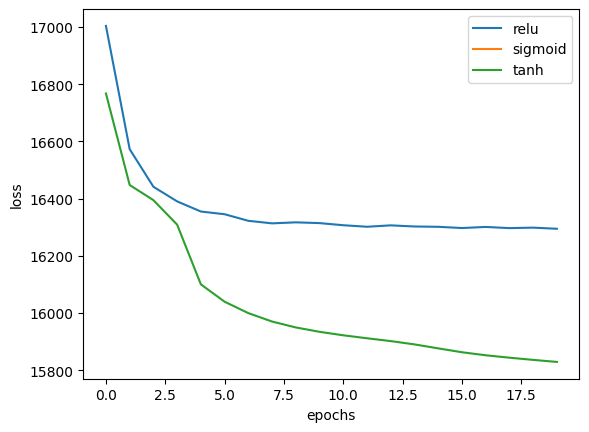

In [64]:
plt.plot( metrics_relu[0], label='relu')
plt.plot( metrics_sigm[0], label='sigmoid')
plt.plot( metrics_tanh[0], label='tanh')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

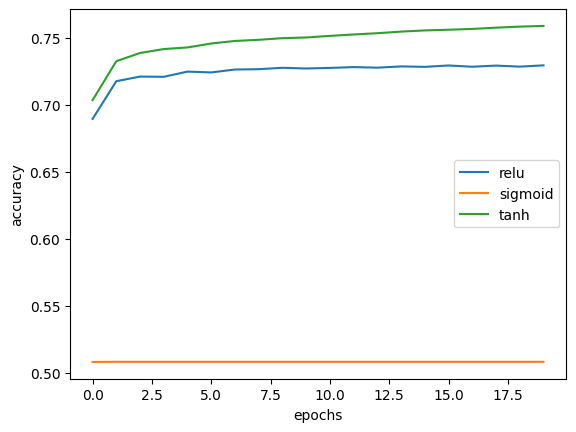

In [65]:
plt.plot( metrics_relu[1], label='relu')
plt.plot( metrics_sigm[1], label='sigmoid')
plt.plot( metrics_tanh[1], label='tanh')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [79]:
print('Testing accuracies are: \n')
print('ReLU :', acc_relu)
print('Sigmoid :', acc_sigm)
print('Tanh :', acc_tanh)

Testing accuracies are: 

ReLU : 0.7416429126716766
Sigmoid : 0.5107540813682301
Tanh : 0.7452707955428868


### **Part 4**

### Random Initialisation

In [67]:
network_random= init( 8, [5], 6,['relu','relu','hi'])
metrics_random =train( network_random, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_random= accuracy( network_random)

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.6972524624157594
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.7240366338344565
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.725073440470019
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.7242958354933472
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.7248142388111284
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.726196647658545
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.7248142388111284
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.7267150509763263
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.7266286504233627
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.7268878520822534
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.72827026092967
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.7279246587178158
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.7290478659063419
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.7283566614826334
>>>epoch:  14 , learning rate:  0.01 , accuracy:

### Constant Initialisation

In [68]:
network_k= init_k( 8, [5], 6,['relu','relu','hi'])
metrics_k =train( network_k, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_k= accuracy( network_k)

<ipython-input-11-bd548474debc>:8: RuntimeWarning: overflow encountered in exp
  y=  1/(1+ np.exp(-x))


>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.5079488508726456
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  14 , learning rate:  0.01 , accur

### Zero Initialisation

In [69]:
network_zero= init_zero( 8, [5], 6,['relu','relu','hi'])
metrics_zero =train( network_zero, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 50, 6)
acc_zero= accuracy( network_zero)

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.5080352514256091
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  14 , learning rate:  0.01 , accur

### Analysis

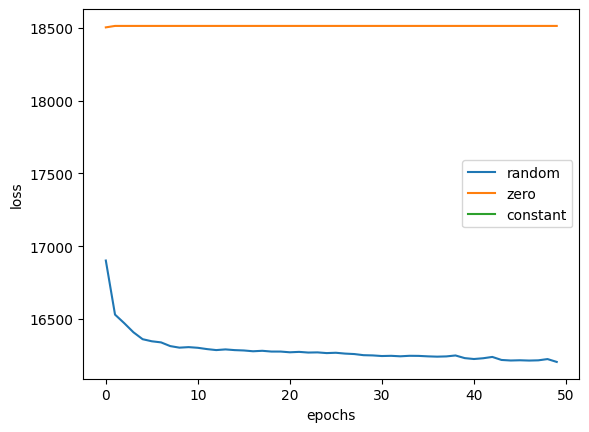

In [70]:
plt.plot( metrics_random[0], label='random')
plt.plot( metrics_zero[0], label='zero')
plt.plot( metrics_k[0], label='constant')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

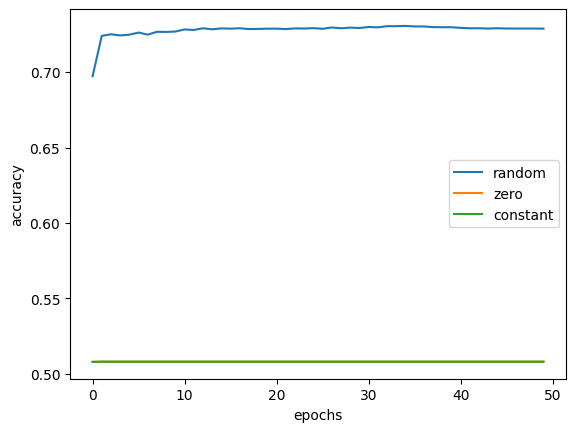

In [71]:
plt.plot( metrics_random[1], label='random')
plt.plot( metrics_zero[1], label='zero')
plt.plot( metrics_k[1], label='constant')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
     

In [80]:
print('Testing accuracies are: \n')
print('Random :', acc_random)
print('Zero :', acc_zero)
print('Constant :', acc_k)

Testing accuracies are: 

Random : 0.7395698367452708
Zero : 0.5107540813682301
Constant : 0.5107540813682301


### **Part 5**

In [73]:
neuron_count = [1, 3, 5, 8, 15]

metric_list=[]
acc_list=[]
for count in neuron_count:
  network= init( 8, [count], 6,['relu','relu','hi'])
  metrics =train( network, np.hstack([X_train,np.array([y_train]).reshape(-1,1)]), 0.01, 20, 6)
  acc= accuracy( network)
  metric_list.append( metrics)
  acc_list.append(acc )

>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.5066528425781925
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  14 , learning rate:  0.01 , accur

<ipython-input-11-bd548474debc>:8: RuntimeWarning: overflow encountered in exp
  y=  1/(1+ np.exp(-x))


>>>epoch:  0 , learning rate:  0.01 , accuracy:  0.6611370312770002
>>>epoch:  1 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  2 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  3 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  4 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  5 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  6 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  7 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  8 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  9 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  10 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  11 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  12 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  13 , learning rate:  0.01 , accuracy:  0.5081216519785726
>>>epoch:  14 , learning rate:  0.01 , accur

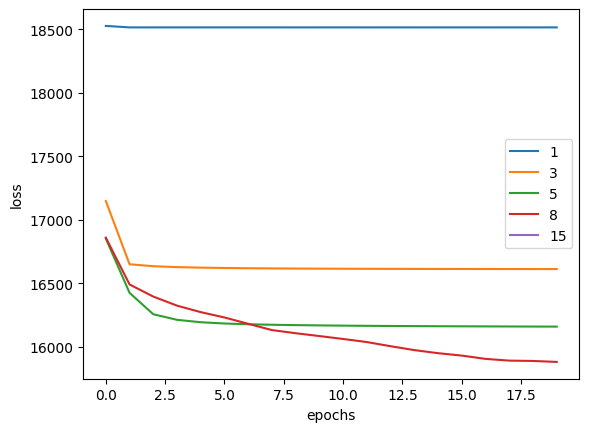

In [74]:
for i in range( len( neuron_count)):
  plt.plot( metric_list[i][0], label= neuron_count[i])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

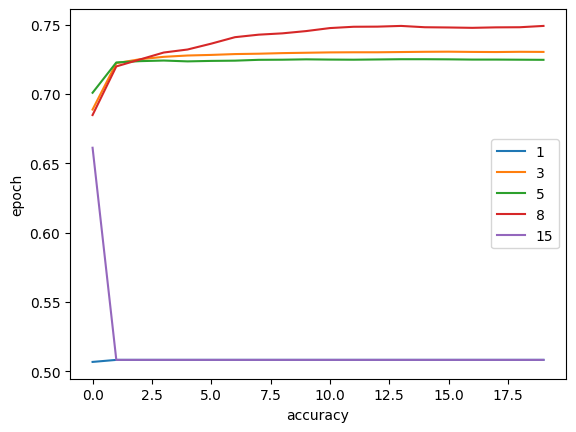

In [75]:
for i in range( len( neuron_count)):
  plt.plot( metric_list[i][1], label= neuron_count[i])
plt.xlabel('accuracy')
plt.ylabel('epoch')
plt.legend()
plt.show()

In [81]:
for i in range( len( neuron_count)):
  print(' With ', neuron_count[i], ' Test accuracy is :', acc_list[i])

 With  1  Test accuracy is : 0.5107540813682301
 With  3  Test accuracy is : 0.7429385851256802
 With  5  Test accuracy is : 0.7447525265612853
 With  8  Test accuracy is : 0.7514900233221041
 With  15  Test accuracy is : 0.5107540813682301


### Saving our model

In [77]:
import pickle 
model = network
with open('model', 'wb') as f: 
  pickle.dump(model, f)

### Loading model

In [82]:
my_model= '/content/model'
with open(my_model, 'rb') as f: 
  my_model = pickle.load(f) 